In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from PIL import Image
import json

### What is the actual goal here?

At a later stage, we want to move images around on a blank canvas. These images are segments of user interfaces. The information where each segment is stored should be stored in a vector containing coordinates for each of the segments on the blank canvas. Lets call it $v$.

Now we want to optimize $v$ to get a higher aesthetic score on the final image (segments on the blank canvas). To do that via an autograd pipeline, we need to find a way to differentiate the aesthetic score $s$ w.r.t. $v$.

This is quite the challenge for a number of reasons:
* "Normal" Array indexing wont work, since this breaks any autograd graphs
* Everything that uses plain integers (instead of floats) as the index is also likely unfeasable, since we only can compute the gradients on floats


In the following, a promising approach is presented, however there is still a challenge to which i dont have a solution right now.

### First Approach
from [https://stackoverflow.com/questions/66987451/image-translation-in-pytorch-using-affine-grid-grid-sample-functions](https://stackoverflow.com/questions/66987451/image-translation-in-pytorch-using-affine-grid-grid-sample-functions)

---
Here we will use [`affine_grid`](https://pytorch.org/docs/stable/generated/torch.nn.functional.affine_grid.html#torch.nn.functional.affine_grid) and [`grid_sample`](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) to move an image around while trying to preserve gradients.

First, we will load one of the UIs of our dataset and extract the first bounding box for this UI:

In [8]:
def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys():
        all_boxes.append(item["bounds"])
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes
"""
returns a list of the segments and a list of coordinates
"""
def segment(image: np.ndarray, rico_json: dict)->[list,list]:
    boxes = get_all_bounding_boxes(rico_json["activity"]["root"])
    segments = []
    coordinates = []
    for box in boxes:
        anchor_point = (box[0],box[1])
        width = box[2]-box[0]
        height = box[3]-box[1]
        cropped_image = im.crop((box[0],box[1],box[2],box[3]))
        # Only include segments that are less than 90% the size of the original image
        if (width*height) < 0.9*(im.size[0]*im.size[1]):
            segments.append(cropped_image)
            coordinates.append((box[0],box[1]))
    return [segments,coordinates]

In [9]:
im = Image.open('combined/5373.jpg')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)
with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

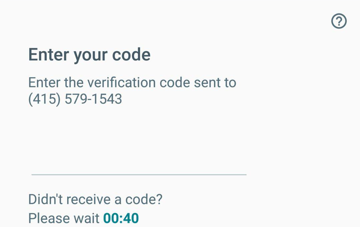

In [28]:
segment_0 =  segment(im,image_json)[0][1]
display(segment_0.resize((int(segment_0.size[0]/4), int(segment_0.size[1]/4))))

In [30]:
transform = transforms.Compose([transforms.ToTensor()])
tensor = transform(im)
dtype =  torch.FloatTensor

Next, we build an affine grid which describes the transformation, which in our case is moving the image to the right. We define a variable `grid_location_x` which we can use to control this. It should be in the range $[-1, 1]$.
In the `rotation_simple` matrix, there are 5 other parameters, which we can use to control y axis moving and rotation around all of the axis.

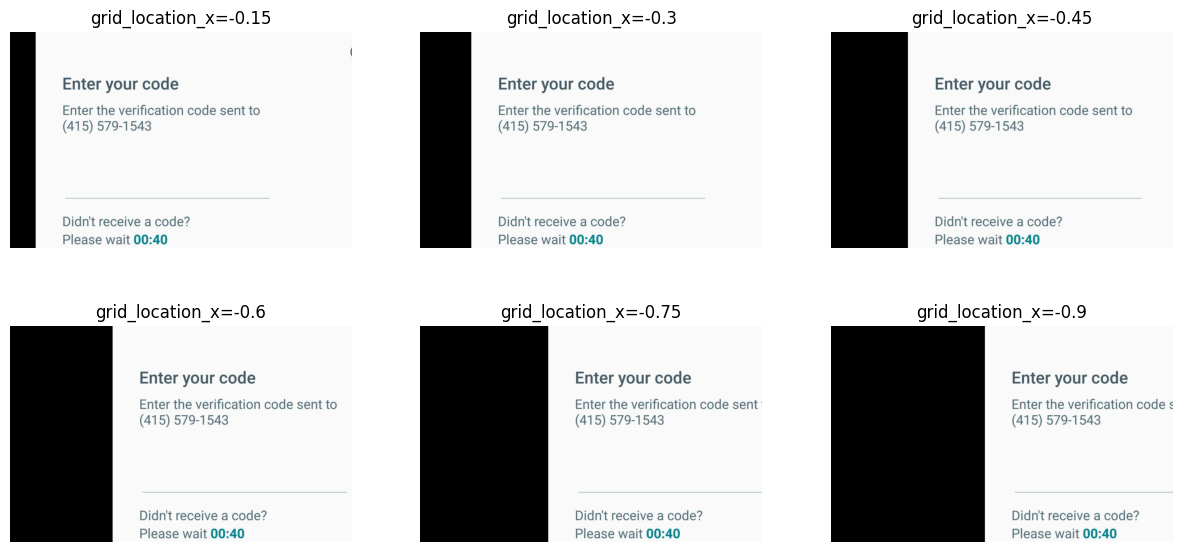

In [27]:
fig = plt.figure(figsize=(15, 7)) 
for n in range(6):
    grid_location_x, grid_location_y = -0.15*(n+1),0.0
    rotation_simple = np.array([[1,0, grid_location_x],
                               [ 0,1, grid_location_y]])
    rotation_simple_tensor = torch.as_tensor(rotation_simple)[None]
    
    grid = F.affine_grid(rotation_simple_tensor, transform(segment_0).unsqueeze(0).size(),align_corners=False).type(dtype)
    
    x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)
    fig.add_subplot(2, 3, n+1) 
    plt.imshow(x[0].permute(1, 2, 0))
    plt.axis('off') 
    plt.title(f"grid_location_x={round(-0.15*(n+1),2)}")

As you can see, we can reliably use this to move an image around. However, the question remains, if we can pass a autograd gradient through this. Lets try this out:

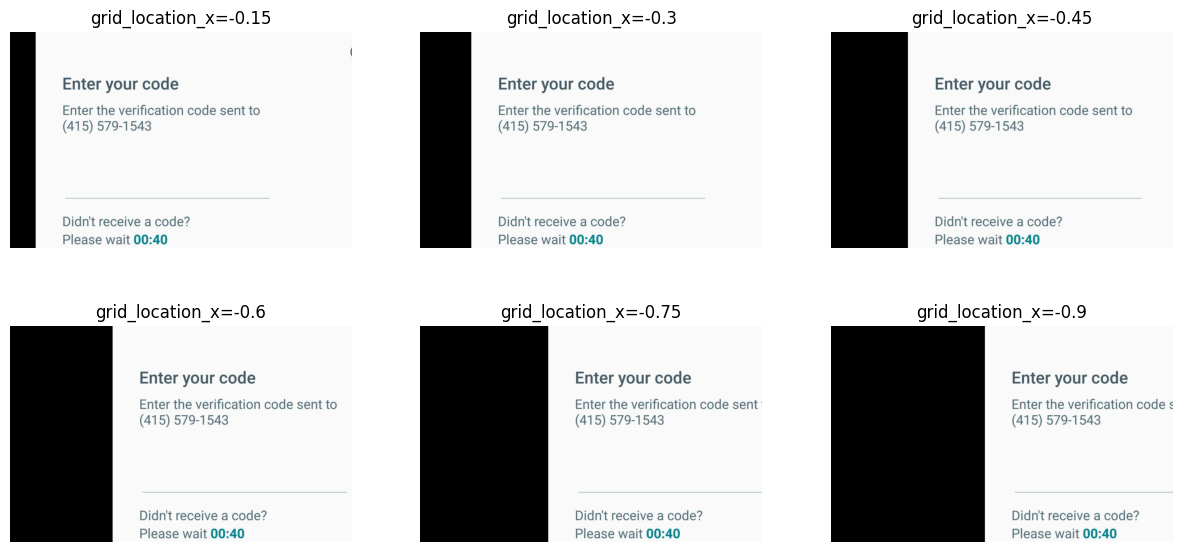

In [38]:
fig = plt.figure(figsize=(15, 7)) 
for n in range(6):
    grid_location_x, grid_location_y = -0.15*(n+1),0.0
    rotation_simple = np.array([[1,0, grid_location_x],
                               [ 0,1, grid_location_y]])
    rotation_simple_tensor = torch.as_tensor(rotation_simple)[None]
    #### Start recording autograd ops
    rotation_simple_tensor.requires_grad_()
    ####
    
    grid = F.affine_grid(rotation_simple_tensor, transform(segment_0).unsqueeze(0).size(),align_corners=False).type(dtype)
    
    x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)

    print(x[0].grad_fn)
    
    fig.add_subplot(2, 3, n+1) 
    plt.imshow(x[0].detach().permute(1, 2, 0))
    plt.axis('off') 
    plt.title(f"grid_location_x={round(-0.15*(n+1),2)}")

Of course we have to call `.detach()` before we pass the image to matplotlib, but this doesnt matter, as you can see, the generated images/matrices still contain the gradient, so this worked!

#### Remaining challenges

While this approach seems promising, some challenges remain. I am currently unsure if it is possible to move a segment on a bigger canvas around and not just on a blank canvas that has the same size as the segment itself.
And even if that would be possible, this is just for one segment, so for multiple segments, we need to layer these transformed images on top of each other, which is probably also a big challenge when wanting to preserve gradients.

### Second Approach
from [https://stackoverflow.com/questions/69752807/differentiable-affine-transformation-on-patches-of-images-in-pytorch](https://stackoverflow.com/questions/69752807/differentiable-affine-transformation-on-patches-of-images-in-pytorch)

---
Lets start with a 9x9 matrix that will act as our blank canvas

In [114]:
x = torch.zeros(9,9,dtype=float, requires_grad=False)

In [115]:
x

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

Now we will define a 4x1 matrix that will represent one of the segments that we want to "draw" on our canvas

In [122]:
values = torch.randint(0, 100, (4,1), dtype=float, requires_grad=False)

In [123]:
values

tensor([[ 4.],
        [61.],
        [ 6.],
        [68.]], dtype=torch.float64)

Next, we randomly generate the lower left edge coordinate where this segment will be put on our canvas and add the upper right coordinate according to our segment size.

In [124]:
x1, y1 = torch.randint(0, 3, (2,))
x2, y2 = x1+4, y1+1
x1, y1, x2, y2

(tensor(2), tensor(2), tensor(6), tensor(3))

Because we will use the `index_put` method from torch, which requires an index for each individual value of the segment matrix, we need to do some `arange` magic, which will transform a tuple $(0,5)$ into an array $[0,1,2,3,4,5]$.
We also need to sort the random values first, for `arange` to work.

In [125]:
sorted_range = lambda a, b: torch.arange(a, b) if b >= a else torch.arange(b, a)
print(x1,y1,x2,y2)
xi, yi = sorted_range(x1, x2), sorted_range(y1, y2)
print(xi, yi)

tensor(2) tensor(2) tensor(6) tensor(3)
tensor([2, 3, 4, 5]) tensor([2])


Then, we create a meshgrid to be used in `index_put`

In [138]:
i, j = torch.meshgrid(xi, yi)
i,j

(tensor([[2],
         [3],
         [4],
         [5]]),
 tensor([[2],
         [2],
         [2],
         [2]]))

In [139]:
i

tensor([[2],
        [3],
        [4],
        [5]])

Now, we can finally use `index_put` to "draw" the segment onto our canvas.

In [142]:
x.index_put(indices=(i, j), values=values)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 61.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 68.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=torch.float64)

But, we see that no autograd gradient is present (not surprising, since we never explicitly defined the index tensor to require autograd). This will also be impossible to accomplish, since `index_put` expects an `int` index and, as mentioned earlier, we cant compute gradients on int tensors.